In [1]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand

pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
alpha = 1/132.507 # alpha QED

# e+e- COM energy in GeV
ECM = 90
hats = ECM ** 2

print('ECM', ECM, 'GeV')

RMAX = 1
D = 1 # no. of integral dimensions
bins = 100
bins_rap = bins
bins_trans = bins
k = pb_convert * ((np.pi * alpha ** 2) / (2 * hats))

def fn(x):
    dx = 0.0
    for d in range(D):
        dx += x[d] # x[d] is integ. point in each dimension 
    #theta = np.arccos(dx)
    #rap_P = -np.log(np.tan(0.5 * theta))
    p_trans = 0.5 * ECM * (1 - dx ** 2) ** 0.5
    #p_trans = 0.5 * ECM * np.sin(theta)
    rap_P = -0.5 * np.log((1 - dx) / (1 + dx))
    I_cos = k * (1 + dx ** 2)
    I_rap = 8 * k * (np.exp(-2 * rap_P) * (np.exp(-4 * rap_P) + 1)) / (np.exp(-2 * rap_P) + 1) ** 4
    I_trans = -(8 / hats) * (pb_convert ** 0.5) * k * (2 * p_trans ** 2 / ECM ** 2 - 1) * (p_trans / (1 - 4 * p_trans ** 2 / ECM ** 2) ** 0.5)
    #print(I_cos, I_rap, I_trans)
    dI_trans = np.zeros(bins_trans, dtype=float)
    dI_rap = np.zeros(bins_rap, dtype=float)
    dI_cos = np.zeros(bins, dtype=float) # list of bins zero entries, note fn called nitn*neval*D (+1) times
    dr_cos = 2 * 1 / len(dI_cos) # defines bins in r (or x)
    j = int((dx + 1) / dr_cos) # defines positive labels for the bins
    dI_cos[j] = I_cos
    dI_rap[j] = I_rap
    dI_trans[j] = I_trans
    return dict(I_cos=I_cos, dI_cos=dI_cos, I_rap=I_rap, dI_rap=dI_rap, I_trans=I_trans, dI_trans=dI_trans)

integ_hist = vegas.Integrator(D * [(-1, 1)])

# results returned in a dictionary
nevals = 10  ** 5
nitns = 2
sigma_hist = integ_hist(fn, nitn = nitns, neval = nevals, adapt = False)
print(sigma_hist.summary())
#print('dI/I =', sigma_hist['dI'] / sigma_hist['I']) #normalised cross-section
print('Sum(dI/I cos) =', sum(sigma_hist['dI_cos']) / sigma_hist['I_cos']) #should be 1
print('Sum(dI/I rap) =', sum(sigma_hist['dI_rap']) / sigma_hist['I_rap']) #should be 1
print('Sum(dI/I trans) =', sum(sigma_hist['dI_trans']) / sigma_hist['I_trans']) #should be 1

# calculate cross sections and error
computed_cos = sigma_hist['I_cos'].mean
computed_rap = sigma_hist['I_rap'].mean
computed_trans = sigma_hist['I_trans'].mean
analytic = (4 * np.pi * alpha ** 2) / (3 * hats)
error_cos = sigma_hist['I_cos'].sdev
error_rap = sigma_hist['I_rap'].sdev
error_trans = sigma_hist['I_trans'].sdev

# don't forget to convert the GeV^-2 to pb! 
print('Vegas Cross-Section cos = '+str(computed_cos)+' +/ '+str(error_cos)+' pb')
print('Vegas Cross-Section rap = '+str(computed_rap)+' +/ '+str(error_rap)+' pb')
print('Vegas Cross-Section trans = '+str(computed_trans)+' +/ '+str(error_trans)+' pb')
print('Analytical Cross-Section = '+str(analytic * pb_convert)+' pb')

ECM 90 GeV
itn   integral        average         chi2/dof        Q
-------------------------------------------------------
  1   11.4689031(15)  11.4689031(15)      0.00     1.00
  2   11.4689008(15)  11.4689019(11)      0.02     1.00

Sum(dI/I cos) = 1.0000000000000(27)
Sum(dI/I rap) = 1.000000000000(48)
Sum(dI/I trans) = 1.000000000(23)
Vegas Cross-Section cos = 11.468901930775449 +/ 1.0910491123664801e-06 pb
Vegas Cross-Section rap = 6.881344341768898 +/ 1.4285549069669242e-06 pb
Vegas Cross-Section trans = 55924.84772874156 +/ 7553.893487832979 pb
Analytical Cross-Section = 11.468903393827555 pb


In [10]:
sigma_hist['dI_cos'][0]

0.17032439(19)

In [8]:
sigma_hist['dI_cos'][0].sdev

1.8773431818374005e-07

In [12]:
sigma_hist['dI_cos'][0].mean

0.1703243869666206

In [11]:
sigma_hist['I_cos'].mean

11.468901930775449

In [17]:
(sigma_hist['dI_cos'][0] / sigma_hist['I_cos']).sdev

1.6185836081773663e-08

In [20]:
sigma_hist['dI_cos'][0].sdev / sigma_hist['I_cos'].mean

1.6368988009216217e-08

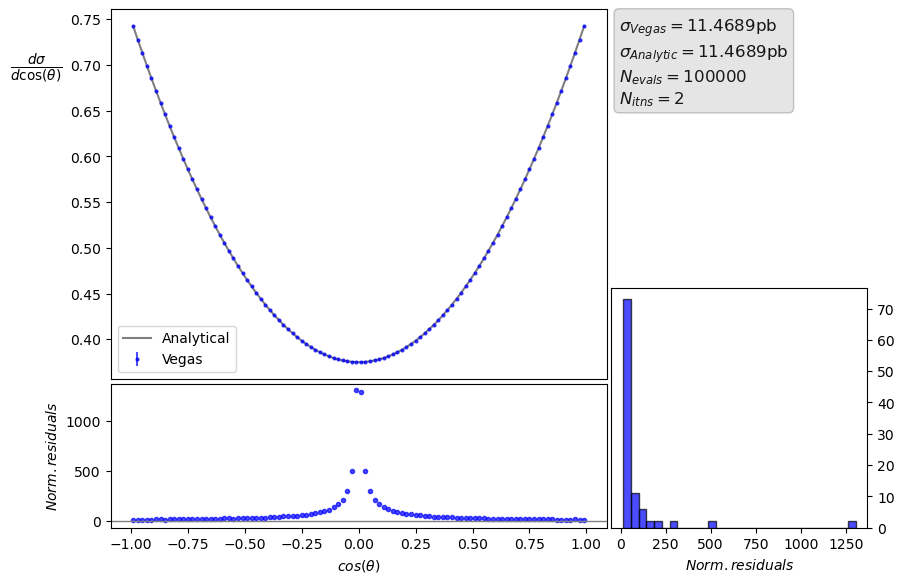

In [21]:
def func(n, x):
    return n * (pb_convert / computed_cos) * (1 + x ** 2)

dIs = []
dI_errs = []
for i in sigma_hist['dI_cos']:
    dIs += [i.mean / sigma_hist['I_cos'].mean]
    dI_errs += [i.sdev / sigma_hist['I_cos'].mean]

xs = np.linspace(-RMAX + (RMAX / bins), RMAX - (RMAX / bins), bins)

fig, ax = plt.subplots()

y = func((np.pi * alpha ** 2) / (2 * hats), xs) 

ax.plot(xs, y, color = 'black', alpha = 0.5, label = 'Analytical')
ax.errorbar(xs, np.array(dIs) * (bins / 2), color = 'blue', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs) * (bins / 2))
ax.axes.get_xaxis().set_visible(False)
plt.ylabel(r'$\frac{d\sigma}{d\cos(\theta)}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()

textstr = '\n'.join((
    r'$\sigma_{Vegas}=$' +str(round(computed_cos, 4))+ 'pb',
    r'$\sigma_{Analytic}=$' +str(round(analytic * pb_convert, 4))+ 'pb',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

residuals = (np.array(dIs) * (bins / 2) - y) / (np.array(dI_errs) * (bins / 2))
ax2 = plt.figure(1).add_axes([0.9075, -0.2, 0.4, 0.5])
plt.hist(residuals, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.7)
ax2.yaxis.tick_right()
plt.xlabel('$Norm. residuals$')

plt.figure(1).add_axes([0.125, -0.2, 0.775, 0.3])
plt.axhline(y = 0, color = 'gray', linewidth = 1)
plt.scatter(xs, residuals, marker = '.', color = 'blue', alpha = 0.7)
plt.ylabel('$Norm. residuals$')
plt.xlabel(r'$cos(\theta)$')
plt.show()

In [15]:
dIs[0], dI_errs[0]

(0.014850975969161892, 1.6185836081773663e-08)

In [11]:
xs, 2/bins

(array([-0.98, -0.94, -0.9 , -0.86, -0.82, -0.78, -0.74, -0.7 , -0.66,
        -0.62, -0.58, -0.54, -0.5 , -0.46, -0.42, -0.38, -0.34, -0.3 ,
        -0.26, -0.22, -0.18, -0.14, -0.1 , -0.06, -0.02,  0.02,  0.06,
         0.1 ,  0.14,  0.18,  0.22,  0.26,  0.3 ,  0.34,  0.38,  0.42,
         0.46,  0.5 ,  0.54,  0.58,  0.62,  0.66,  0.7 ,  0.74,  0.78,
         0.82,  0.86,  0.9 ,  0.94,  0.98]),
 0.04)

In [8]:
np.sum(y)

24.997497068761014

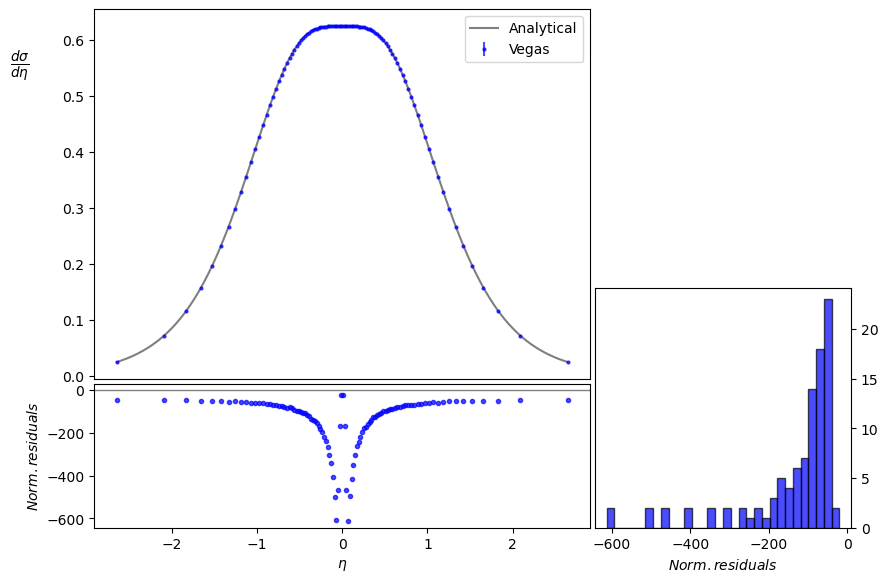

In [22]:
def rap_func(n, x):
    b = (np.exp(-2 * x) * (np.exp(-4 * x) + 1)) / (np.exp(-2 * x) + 1) ** 4
    return (pb_convert / computed_rap) * n * b

dIs_rap = []
dI_errs_rap = []
for i in sigma_hist['dI_rap']:
    dIs_rap += [i.mean / sigma_hist['I_rap'].mean]
    dI_errs_rap += [i.sdev / sigma_hist['I_rap'].mean]

xs_rap = -np.log(np.tan(0.5 * np.arccos(xs)))
ps = np.linspace(min(xs_rap), max(xs_rap), 100)

fig, ax = plt.subplots()

y_rap = rap_func((4 * np.pi * alpha ** 2) / hats, xs_rap) 
y_ps = rap_func((4 * np.pi * alpha ** 2) / hats, ps)

ax.plot(ps, y_ps, color = 'black', alpha = 0.5, label = 'Analytical')
ax.errorbar(xs_rap, np.array(dIs_rap) * (bins_rap / 2), color = 'blue', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs_rap) * (bins_rap / 2))
ax.axes.get_xaxis().set_visible(False)
plt.ylabel(r'$\frac{d\sigma}{d\eta}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()

residuals_rap = (np.array(dIs_rap) * (bins_rap / 2) - y_rap) / (np.array(dI_errs_rap) * (bins_rap / 2))
ax2 = plt.figure(1).add_axes([0.9075, -0.2, 0.4, 0.5])
plt.hist(residuals_rap, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.7)
ax2.yaxis.tick_right()
plt.xlabel('$Norm. residuals$')

plt.figure(1).add_axes([0.125, -0.2, 0.775, 0.3])
plt.axhline(y = 0, color = 'gray', linewidth = 1)
plt.scatter(xs_rap, residuals_rap, marker = '.', color = 'blue', alpha = 0.7)
plt.ylabel('$Norm. residuals$')
plt.xlabel(r'$\eta$')
plt.show()

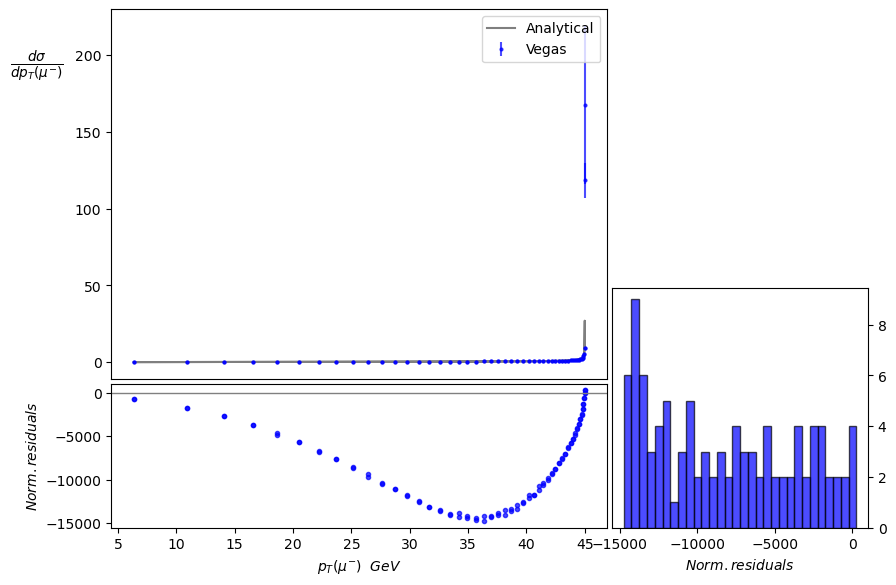

In [23]:
def trans_func(n, x):
    b = -(8 / hats) * (pb_convert ** 0.5) * (2 * x ** 2 / ECM ** 2 - 1) * (x / (1 - 4 * x ** 2 / ECM ** 2) ** 0.5)
    return (pb_convert / computed_trans) * n * b

dIs_trans = []
dI_errs_trans = []
for i in sigma_hist['dI_trans']:
    dIs_trans += [i.mean / sigma_hist['I_trans'].mean]
    dI_errs_trans += [i.sdev / sigma_hist['I_trans'].mean]

#xs_trans = 0.5 * ECM * np.sin(np.arccos(xs))
xs_trans = 0.5 * ECM * (1 - xs ** 2) ** 0.5
ps_t = np.linspace(min(xs_trans), max(xs_trans), 1000)

fig, ax = plt.subplots()

y_trans = trans_func((4 * np.pi * alpha ** 2) / hats, xs_trans) 
y_ps_t = trans_func((4 * np.pi * alpha ** 2) / hats, ps_t)

ax.plot(xs_trans, y_trans, color = 'black', alpha = 0.5, label = 'Analytical')
ax.errorbar(xs_trans, np.array(dIs_trans) * (bins_trans) * pb_convert * 10 ** (-8), color = 'blue', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs_trans) * (bins_trans) * pb_convert * 10 ** (-8))
ax.axes.get_xaxis().set_visible(False)
plt.ylabel(r'$\frac{d\sigma}{dp_T(\mu^{-})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
#plt.ylim(0, max(y_trans))
plt.legend()

residuals_trans = (np.array(dIs_trans) * (bins_trans) * pb_convert * 10 ** (-8) - y_trans) / (np.array(dI_errs_trans) * (bins_trans) * pb_convert * 10 ** (-8))
ax2 = plt.figure(1).add_axes([0.9075, -0.2, 0.4, 0.5])
plt.hist(residuals_trans, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.7)
ax2.yaxis.tick_right()
plt.xlabel('$Norm. residuals$')

plt.figure(1).add_axes([0.125, -0.2, 0.775, 0.3])
plt.axhline(y = 0, color = 'gray', linewidth = 1)
plt.scatter(xs_trans, residuals_trans, marker = '.', color = 'blue', alpha = 0.7)
plt.ylabel('$Norm. residuals$')
plt.xlabel(r'$p_T(\mu^{-})$  $GeV$')
plt.show()

In [21]:
np.array(dIs_trans) * (bins_trans)

array([ 0.0293193 ,  0.05319044,  0.06842164,  0.08063789,  0.09122896,
        0.10086642,  0.10996931,  0.11884979,  0.1277744 ,  0.13699701,
        0.14678651,  0.15744651,  0.16934428,  0.18294491,  0.1988695 ,
        0.21797642,  0.24151088,  0.27136484,  0.31058398,  0.36443496,
        0.44290574,  0.56763775,  0.79638901,  1.35715859, 18.2124676 ,
       19.10231573,  1.35717644,  0.79638698,  0.56763203,  0.44290317,
        0.36443242,  0.31058376,  0.2713652 ,  0.24151032,  0.21797708,
        0.19886933,  0.18294499,  0.16934325,  0.15744637,  0.14678656,
        0.1369973 ,  0.12777411,  0.11884983,  0.10996903,  0.10086601,
        0.09122861,  0.08063764,  0.06842212,  0.05319029,  0.02931477])

In [22]:
y_trans / (np.array(dIs_trans) * (bins_trans))

array([4.24610752, 4.01959342, 4.00680073, 4.0032312 , 4.00169417,
       4.00085284, 4.0003239 , 3.99993801, 3.99960895, 3.99932294,
       3.99902288, 3.99870058, 3.99832857, 3.99790779, 3.99736753,
       3.99667186, 3.99572537, 3.99439246, 3.99241499, 3.98923741,
       3.98373539, 3.97292665, 3.94631807, 3.84745928, 0.85874929,
       0.81874595, 3.84740869, 3.94632811, 3.97296665, 3.98375852,
       3.98926531, 3.9924178 , 3.99438719, 3.99573458, 3.99665976,
       3.99737102, 3.99790622, 3.99835279, 3.99870414, 3.99902152,
       3.99931464, 3.99961813, 3.99993666, 4.00033439, 4.00086896,
       4.00170938, 4.00324341, 4.00677264, 4.01960428, 4.24676358])